In [31]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '/kaggle/input/unetscratch')  
from unet_from_scratch import unet

import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input, concatenate, Flatten, Dropout

In [2]:
#Allocating multiple gpus for training
strategy = tf.distribute.MirroredStrategy()

In [3]:
image_dir = '/kaggle/input/ham1000-segmentation-and-classification/images/'
mask_dir = '/kaggle/input/ham1000-segmentation-and-classification/masks/'

imgsort = sorted(os.listdir(image_dir))[1:-1]
masksort = sorted(os.listdir(mask_dir))

In [4]:
len(imgsort), len(masksort)

(10015, 10015)

In [5]:
#loading the images, converting them to grayscale and resizing them to (256,256)
def load_images(imgsort, masksort, image_dir, mask_dir):
    images, masks = [], []

    for img, msk in tqdm(zip(imgsort, masksort), total = len(imgsort), desc = 'Loading Images and Masks'):
        image = cv2.imread(image_dir + img, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_dir + msk, cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (256,256))
        mask = cv2.resize(mask, (256,256))

#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        images.append(image)
        masks.append(mask)

        del image, mask
        
    return images, masks
    
images, masks = load_images(imgsort, masksort, image_dir, mask_dir)

Loading Images and Masks: 100%|██████████| 10015/10015 [02:52<00:00, 58.13it/s]


In [6]:
len(images), len(masks)

(10015, 10015)

In [7]:
#Visualizing Images and Masks for Sanity

def plot_image_with_mask(image_list, mask_list, num_pairs = 4):
    plt.figure(figsize = (18,9))
    for i in range(num_pairs):
        idx = random.randint(0, len(image_list))
        img = image_list[idx]
        mask = mask_list[idx]
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(f'Real Image, index = {idx}')
        plt.axis('off')
        plt.subplot(2, 4, i + num_pairs + 1)
        plt.imshow(mask)
        plt.title(f'Segmented Image, index = {idx}')
        plt.axis('off')
        del img, mask

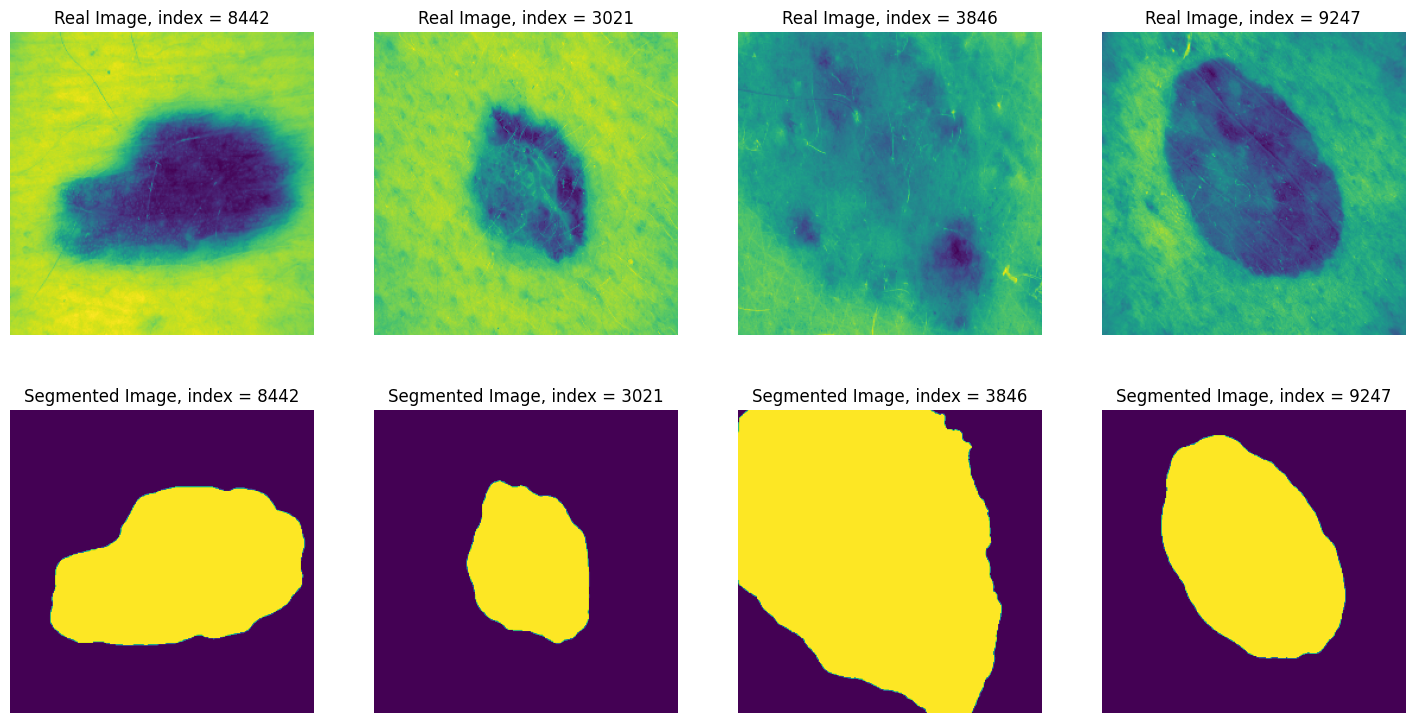

In [8]:
plot_image_with_mask(images, masks, num_pairs = 4)

In [9]:
#Converting the images to tensors to make it tensorflow compatible
def to_tensor(image_list, mask_list):
    tensor_images = tf.convert_to_tensor(tf.cast(np.array(image_list),  dtype = tf.float32))/255
    tensor_masks = tf.convert_to_tensor(tf.cast(np.array(mask_list), dtype= tf.float32))/255
    return tensor_images, tensor_masks

In [10]:
images, masks = to_tensor(images, masks)

In [11]:
#splitting the images and masks into train, test and split
train_split = tf.cast(tf.round(len(images)*0.6) - 1, dtype = tf.int32)
test_val_split = tf.cast(tf.round(len(images)*0.2), dtype = tf.int32)

images_train = images[:train_split]
masks_train = masks[:train_split]

images_val = images[train_split:train_split + test_val_split]
masks_val = masks[train_split:train_split + test_val_split]

images_test = images[train_split + test_val_split:]
masks_test = masks[train_split + test_val_split:]

del images, masks

print(f'The length of images and masks for training is {len(images_train)} and {len(masks_train)} respectively')
print(f'The length of images and masks for validation is {len(images_val)} and {len(masks_val)} respectively')
print(f'The length of images and masks for testing is {len(images_test)} and {len(masks_test)} respectively')

The length of images and masks for training is 6008 and 6008 respectively
The length of images and masks for validation is 2003 and 2003 respectively
The length of images and masks for testing is 2004 and 2004 respectively


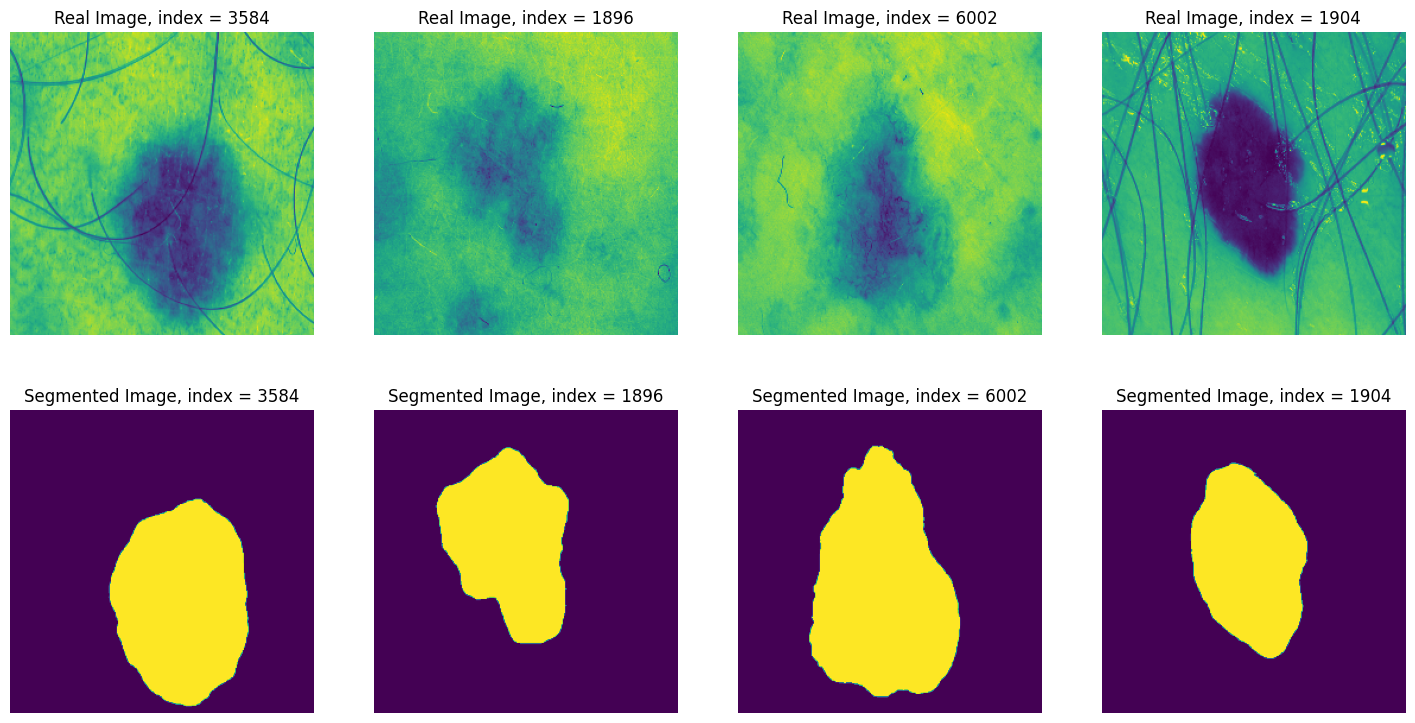

In [12]:
#Again Sanity Check
plot_image_with_mask(images_train, masks_train)

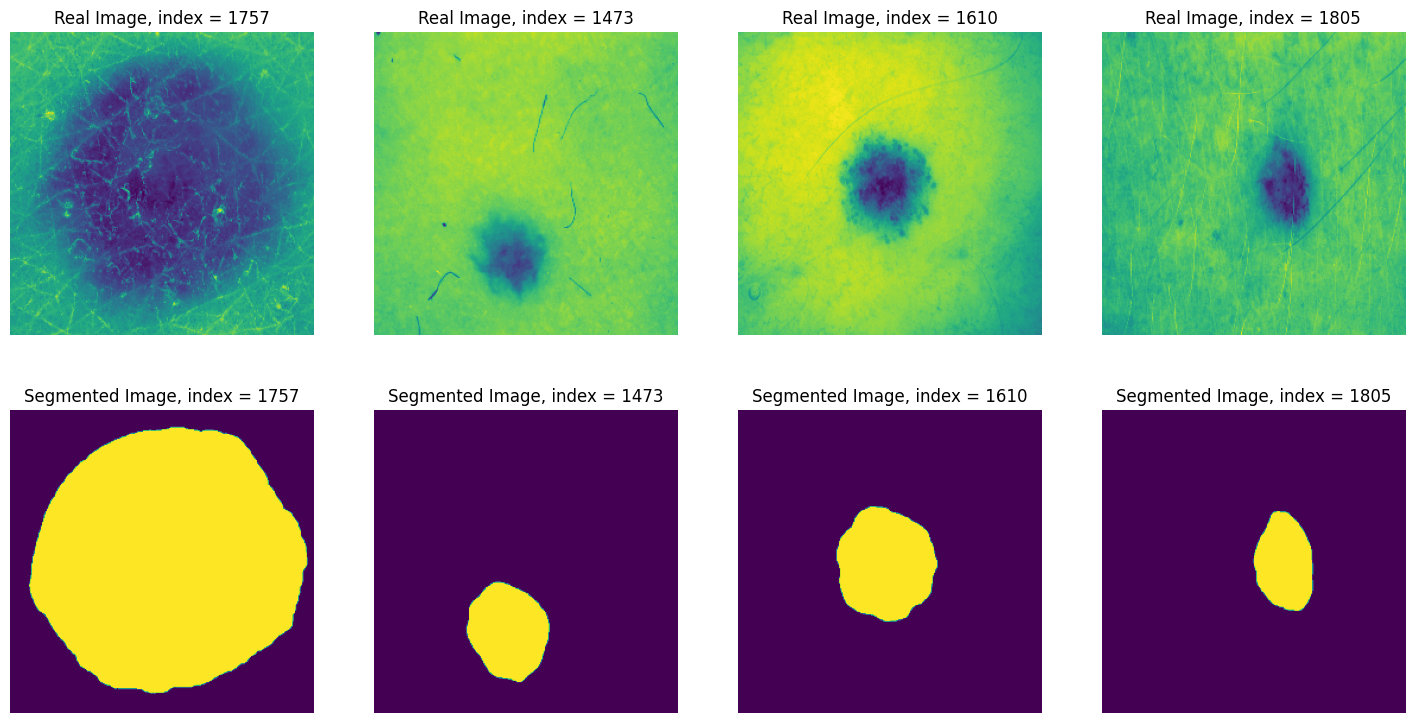

In [13]:
plot_image_with_mask(images_val, masks_val)

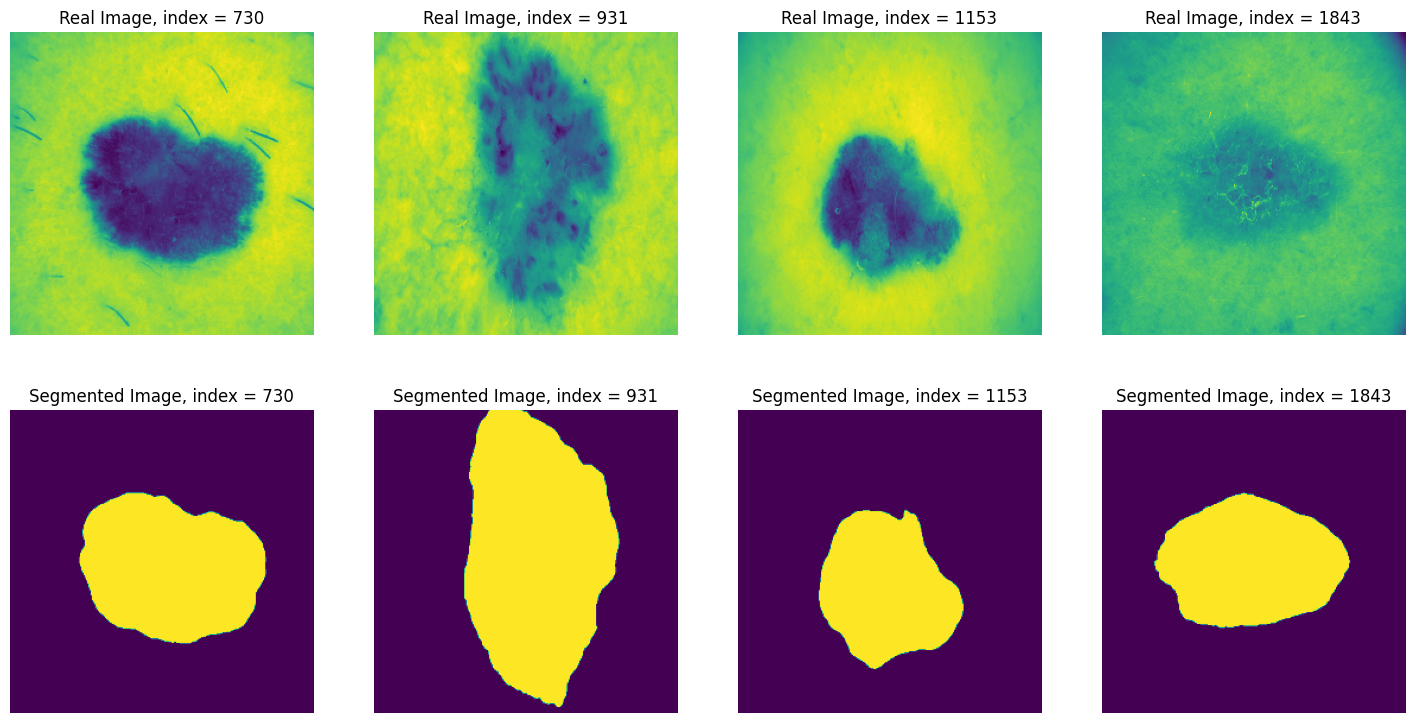

In [14]:
plot_image_with_mask(images_test, masks_test)

In [20]:
#Converting the list of tensors into batches to efficiently train the model, computation-wise
batch_size = 32

train_data = tf.data.Dataset.from_tensor_slices((images_train, masks_train))
train_data = train_data.batch(batch_size)

val_data = tf.data.Dataset.from_tensor_slices((images_val, masks_val))
val_data = val_data.batch(batch_size)

test_data = tf.data.Dataset.from_tensor_slices((images_test, masks_test))
test_data = test_data.batch(batch_size)

# Setting up evaluation metrics

In [21]:
# Setting dice coefficient to evaluate our model
def dice_coeff(y_true, y_pred, smooth = 1):
    intersection = K.sum(y_true*y_pred, axis = -1)
    union = K.sum(y_true, axis = -1) + K.sum(y_pred, axis = -1)
    dice_coeff = (2*intersection+smooth) / (union + smooth)
    return dice_coeff

 # U-NET

In [32]:
with strategy.scope():
    unet = unet()
    unet.compile(loss = 'binary_crossentropy',
            optimizer = 'adam',
            metrics = ['accuracy', dice_coeff])
unet.summary()

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 256, 256, 64)         640       ['input_3[0][0]']             
                                                                                                  
 conv2d_39 (Conv2D)          (None, 256, 256, 64)         36928     ['conv2d_38[0][0]']           
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 128, 128, 64)         0         ['conv2d_39[0][0]']           
 g2D)                                                                                          

In [33]:
#Defining early stopping to regularize the model and prevent overfitting
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

In [37]:
#Training the model with 20 epochs (it will stop training in between because of early stopping)
unet_history = unet.fit(train_data, validation_data = [val_data], 
                        epochs = 50, callbacks = [early_stopping])

Epoch 1/50
188/188 [==============================] - 191s 1s/step - loss: 0.1606 - accuracy: 0.9364 - dice_coeff: 0.6068 - val_loss: 0.1536 - val_accuracy: 0.9371 - val_dice_coeff: 0.6101
Epoch 2/50
188/188 [==============================] - 191s 1s/step - loss: 0.1515 - accuracy: 0.9395 - dice_coeff: 0.6266 - val_loss: 0.1467 - val_accuracy: 0.9398 - val_dice_coeff: 0.6270
Epoch 3/50
188/188 [==============================] - 193s 1s/step - loss: 0.1462 - accuracy: 0.9416 - dice_coeff: 0.6364 - val_loss: 0.1436 - val_accuracy: 0.9410 - val_dice_coeff: 0.6333
Epoch 4/50
188/188 [==============================] - 189s 1s/step - loss: 0.1418 - accuracy: 0.9433 - dice_coeff: 0.6457 - val_loss: 0.1454 - val_accuracy: 0.9407 - val_dice_coeff: 0.6262
Epoch 5/50
188/188 [==============================] - 190s 1s/step - loss: 0.1366 - accuracy: 0.9451 - dice_coeff: 0.6561 - val_loss: 0.1415 - val_accuracy: 0.9424 - val_dice_coeff: 0.6448
Epoch 6/50
188/188 [==============================] - 1

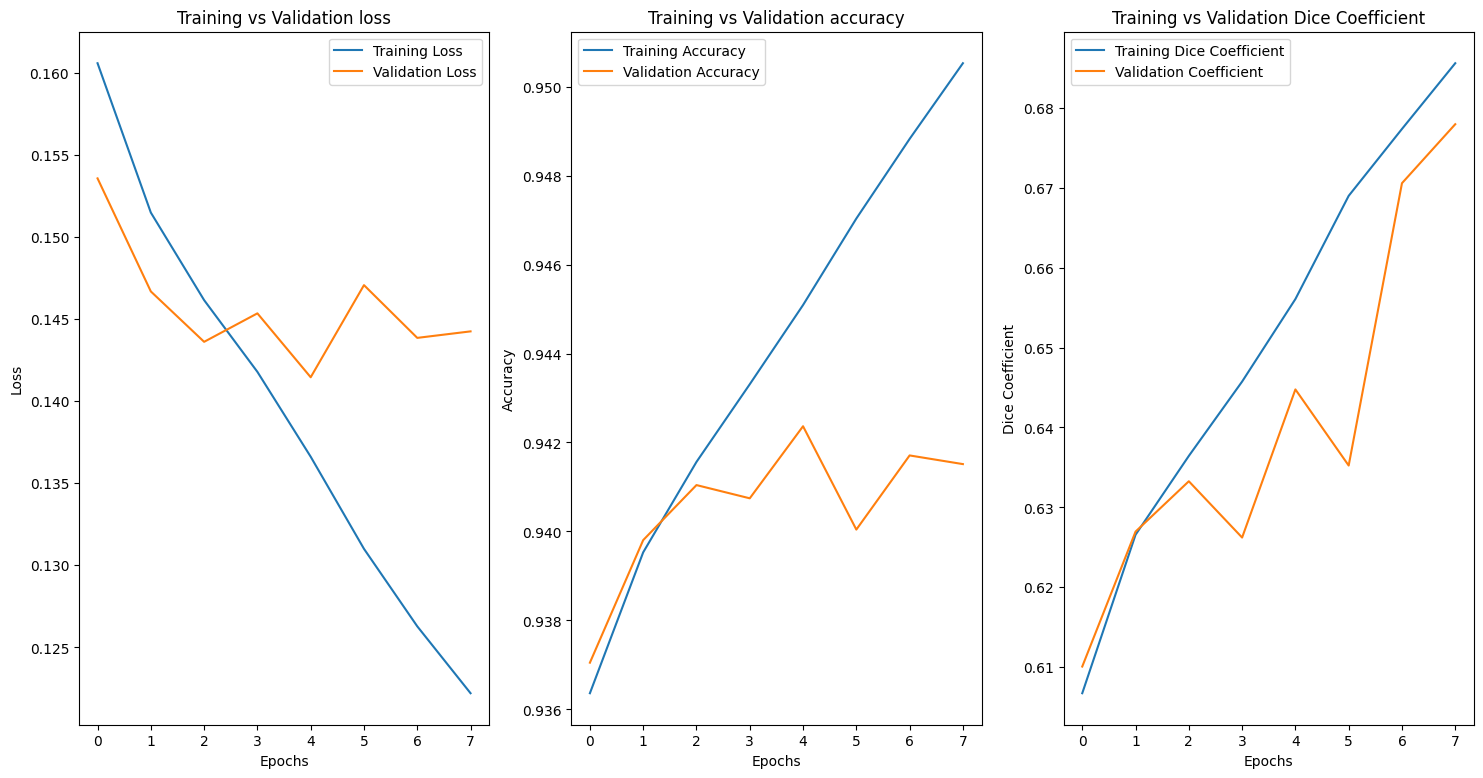

In [38]:
#Plotting the loss and accuracy during training and validation
plt.figure(figsize = (18, 9))
plt.subplot(1,3,1)
plt.plot(unet_history.history['loss'])
plt.plot(unet_history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.subplot(1,3,2)
plt.plot(unet_history.history['accuracy'])
plt.plot(unet_history.history['val_accuracy'])
plt.title('Training vs Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.subplot(1,3,3)
plt.plot(unet_history.history['dice_coeff'])
plt.plot(unet_history.history['val_dice_coeff'])
plt.title('Training vs Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend(['Training Dice Coefficient', 'Validation Coefficient'])

In [39]:
#evaluating the model, we got 89.54% accuracy. Pretty Good!
unet.evaluate(test_data)

63/63 [==============================] - 28s 406ms/step - loss: 0.1170 - accuracy: 0.9547 - dice_coeff: 0.6448


[0.11696050316095352, 0.9547191262245178, 0.6447717547416687]

In [40]:
#Function to plot the predictions with orginal image, original mask and predicted mask
def plot_preds(idx):
    plt.figure(figsize = (15, 15))
    test_img = images_test[idx]
    test_img = tf.expand_dims(test_img, axis = 0)
    test_img = tf.expand_dims(test_img, axis = -1)
    pred = unet.predict(test_img)
    pred = pred.squeeze()
    thresh = pred > 0.5
    plt.subplot(1,3,1)
    plt.imshow(images_test[idx])
    plt.title(f'Original Image {idx}')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(masks_test[idx])
    plt.title('Actual Mask')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(thresh)
    plt.title('Predicted Mask')
    plt.axis('off')
    

1/1 [==============================] - 0s 147ms/step


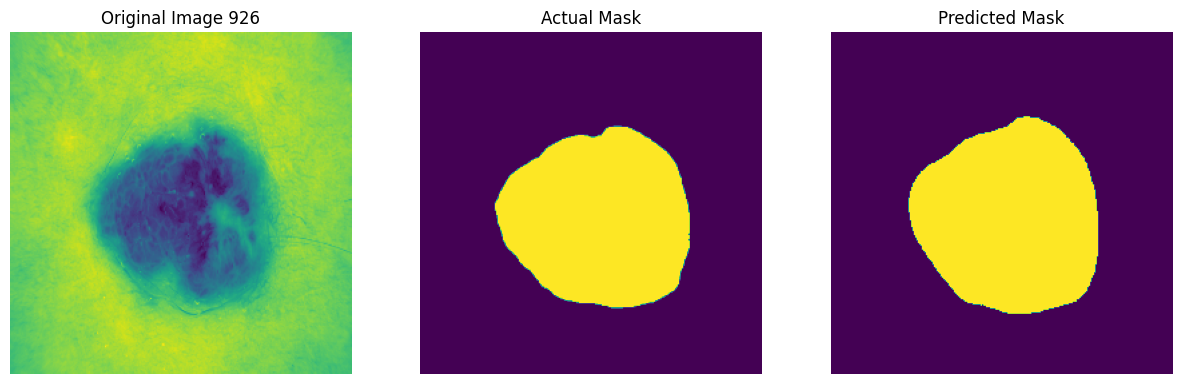

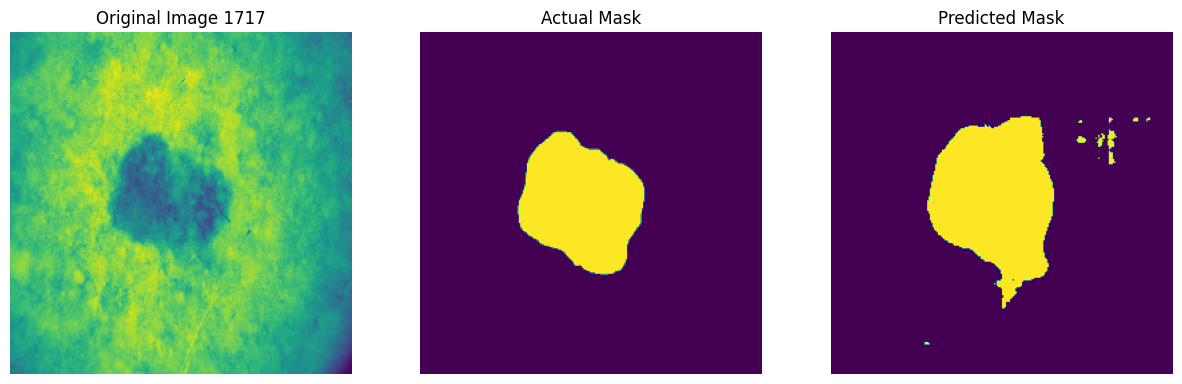

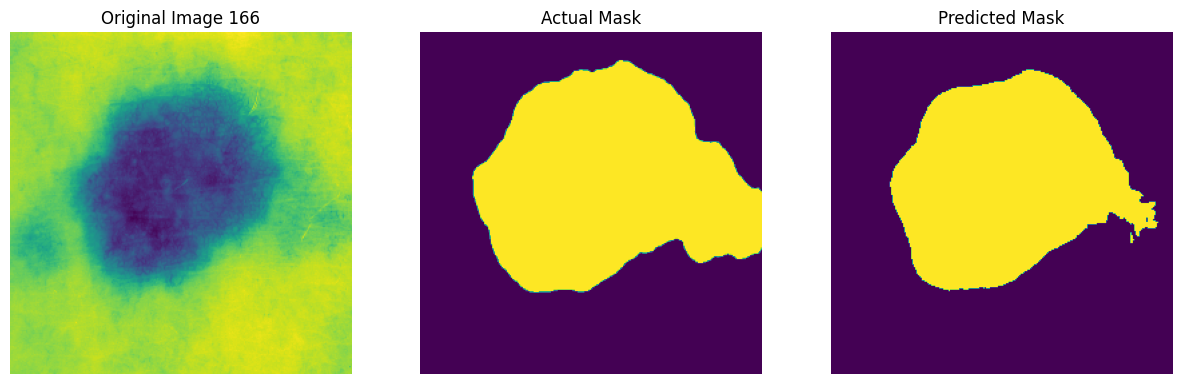

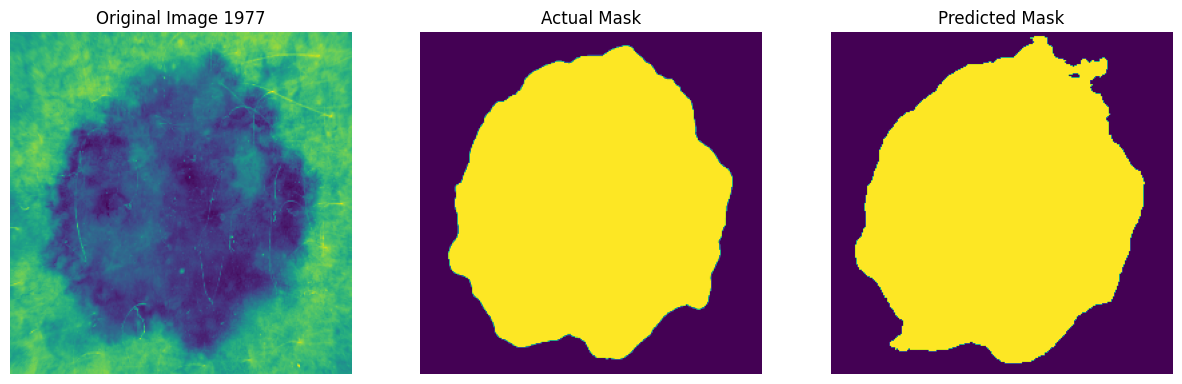

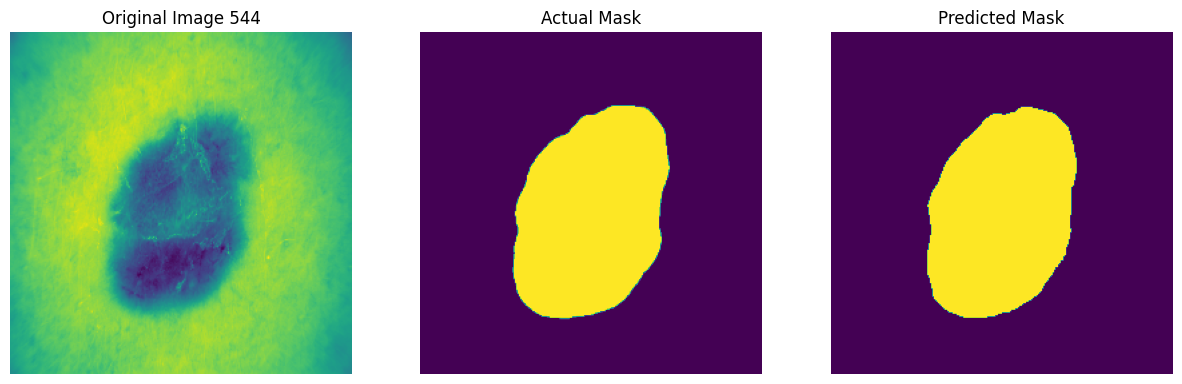

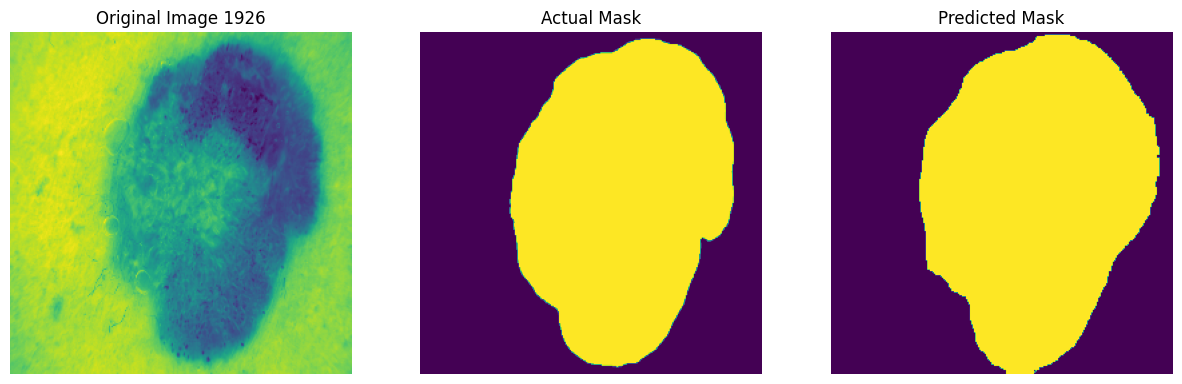

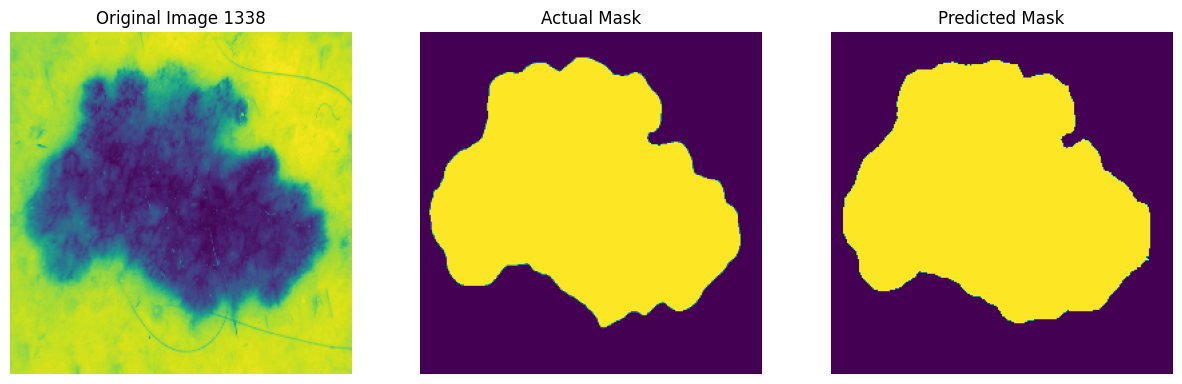

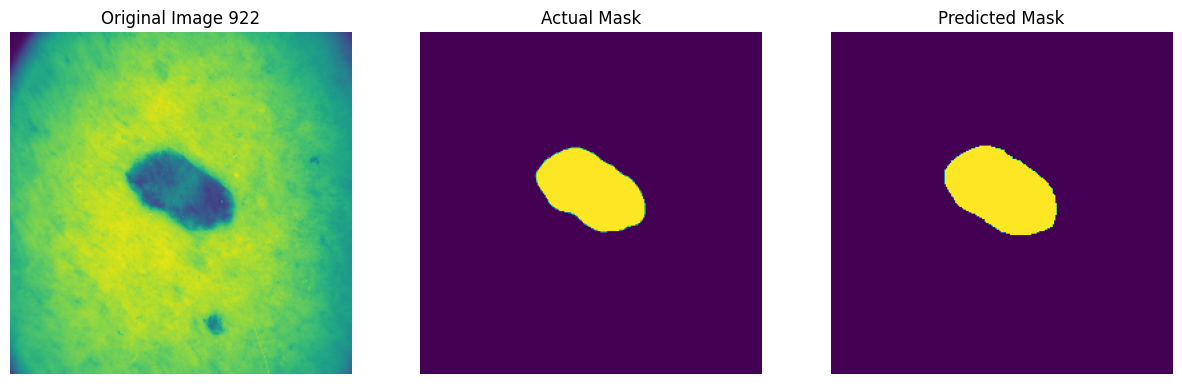

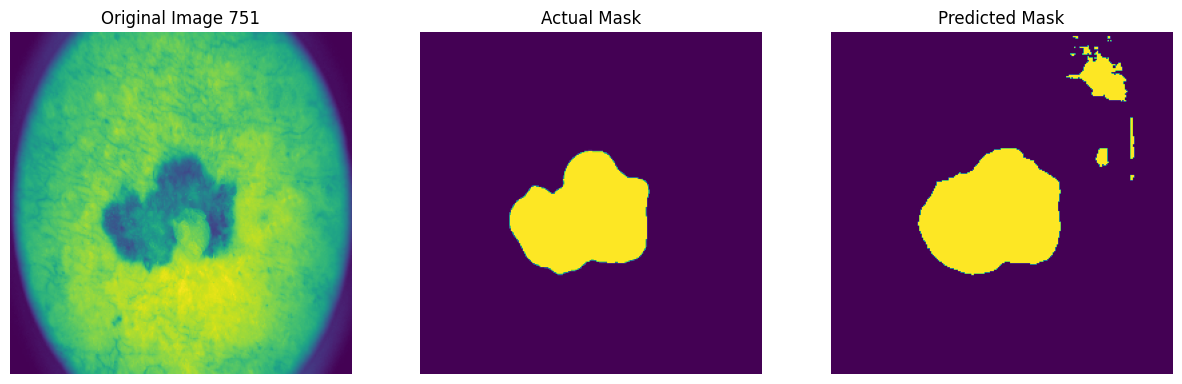

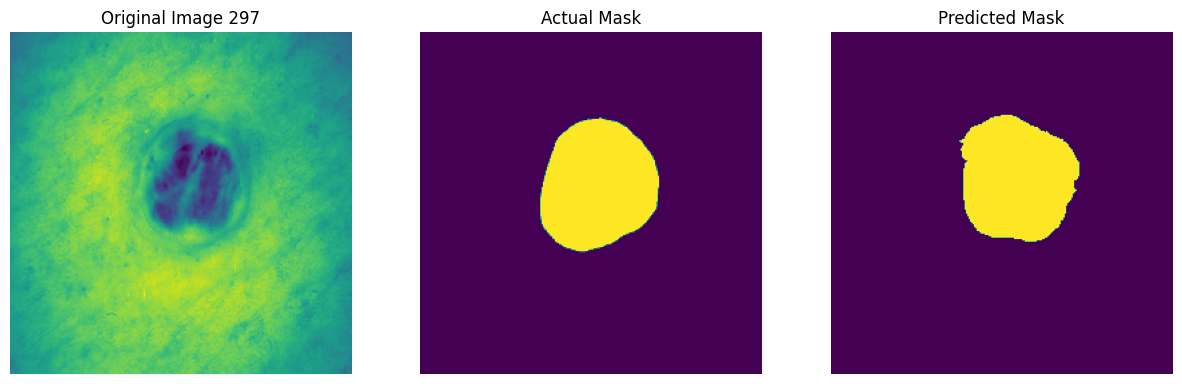

In [46]:
for i in [random.randint(0, 2000) for i in range(10)]:
    plot_preds(i)

In [47]:
#Saving the model
unet.save('unet_skin_cancer')

In [48]:
!zip -r unet_skin_cancer_model.zip '/kaggle/working/unet_skin_cancer'

  adding: kaggle/working/unet_skin_cancer/ (stored 0%)
  adding: kaggle/working/unet_skin_cancer/saved_model.pb (deflated 90%)
  adding: kaggle/working/unet_skin_cancer/assets/ (stored 0%)
  adding: kaggle/working/unet_skin_cancer/keras_metadata.pb (deflated 95%)
  adding: kaggle/working/unet_skin_cancer/variables/ (stored 0%)
  adding: kaggle/working/unet_skin_cancer/variables/variables.data-00000-of-00001 (deflated 19%)
  adding: kaggle/working/unet_skin_cancer/variables/variables.index (deflated 73%)
  adding: kaggle/working/unet_skin_cancer/fingerprint.pb (stored 0%)


In [49]:
from IPython.display import FileLink
FileLink(r'unet_skin_cancer_model.zip')

/kaggle/working/unet_skin_cancer_model.zip